In [48]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os 
import copy
import pickle
import json
import sep

import numpy as np
import numpy.ma as ma
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column, join
from astropy.stats import sigma_clip

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle, Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The layout on the focal plane is from [here](https://github.com/DarkEnergySurvey/despyPIFF/blob/main/python/despyPIFF/DECam_focal_plane.py) and is saved as `https://github.com/MerianSurvey/caterpillar/tree/main/data/decam/decam_fp_layout.json` and `https://github.com/MerianSurvey/caterpillar/tree/main/data/decam/decam_detector_pos.json`.

In [55]:
with open('../../data/decam/decam_fp_layout.json', 'r') as f:
    DECam_FP_layout = json.load(f)
    f.close()
# with open('../../data/decam/decam_detector_pos.json', 'r') as f:
#     detector_pos = json.load(f)
#     f.close()

Text(0, 0.5, 'y (pixels)')

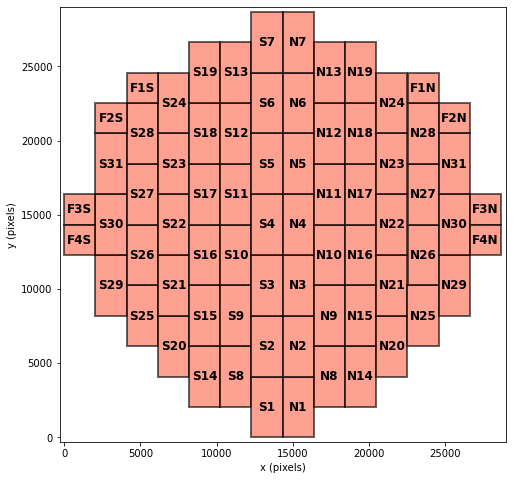

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))

for ccdnum in DECam_FP_layout.keys():

    chip = DECam_FP_layout[ccdnum]
    
    rect = Rectangle(xy=(chip['x1'], chip['y1']), 
                     width=(chip['x2'] - chip['x1']),
                     height=(chip['y2'] - chip['y1']), 
                     linewidth=2,
                     zorder=10,
                     facecolor='tomato',
                     alpha=0.6,
                     edgecolor='k')
    ax.add_artist(rect)
    
    text = chip['name']
    textcolor = 'k'
    
    cx = chip['x1'] + (chip['x2'] - chip['x1']) / 2.0
    cy = chip['y1'] + (chip['y2'] - chip['y1']) / 2.0
    ax.annotate(text, (cx, cy), color=textcolor, weight='bold', 
                fontsize=12, ha='center', va='center', zorder=12)
    
ax.ticklabel_format(style='plain')
plt.xlim(-300, 29000)
plt.ylim(-300, 29000)
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')

In [136]:
filename = 'c4d_210310_041908_oki_N708_v1.fits.fz'
file_dir = '/Users/jiaxuanli/Research/Merian/SN_test/'
hdu = fits.open(os.path.join(file_dir, filename))
hdr = hdu[0].header
r = 1 / 0.2637 # 1 arcsec aperture for photometry
gn = 4.0 # Gain e-/ADU (typica)

In [120]:
import warnings
warnings.filterwarnings('ignore')

In [162]:
S2N_dict = {}

for idx in range(1, len(hdu)):
    data = hdu[idx].data
    w = WCS(hdu[idx].header)
    ccdpos = hdu[idx].header['EXTNAME']
    print('CCD', ccdpos, 'chip', idx)
    
    if 'AVSKY' not in hdu[idx].header:
        print(ccdpos, 'might have problem on sky background, skip this ccd')
        continue
        
    # Subtract background
    bkg = sep.Background(data, bw=128, bh=128, fw=5, fh=5)
    data_sub = data - bkg.back()  # Data - Background
    objects, segmap = sep.extract(data_sub, 1.5, err=bkg.globalrms, segmentation_map=True)  # Objects detected over (,x,)*(,,y)
    objects = Table(objects)
    #objects['ra'], objects['dec'] = w.wcs_pix2world(objects['x'], objects['y'], 0)

    # Find empty region
    obj_mask = np.zeros( data.shape ) # Full of 0.0 initally
    for j in range (0, len(objects) ):
            obj_mask[ int(objects['y'][j]) ][ int(objects['x'][j]) ] = 1.0
            # 'y' represents first dimension in array, 'x' the second dimension
            # For each pixels location (rounded to nearest integer, fill obj_mask
            # array with a 1.0 to represent object at that location     
    masked_data = ma.masked_array(data_sub, mask = obj_mask ) # covers object's centroid locations
    
    N_empty =  1 * len(objects) 
    empty_pos_y = np.empty(N_empty)
    empty_pos_x = np.empty(N_empty)

    for i in range(0, N_empty):
        empty_pos_y[i] = int(np.random.randint(0, data.shape[0] - 4))
        empty_pos_x[i] = int(np.random.randint(0, data.shape[1] - 4))

        for a in range(0, 4):
            for b in range(0, 4):
                while masked_data.mask[int(abs(empty_pos_y[i] + a))][int(
                        abs(empty_pos_x[i] + b))] == True:
                    empty_pos_y[i] = int(np.random.randint(0, data.shape[0] - 4))
                    empty_pos_x[i] = int(np.random.randint(0, data.shape[1] - 4))

                while masked_data.mask[int(abs(empty_pos_y[i] - a))][int(
                        abs(empty_pos_x[i] + b))] == True:
                    empty_pos_y[i] = int(np.random.randint(0, data.shape[0] - 4))
                    empty_pos_x[i] = int(np.random.randint(0, data.shape[1] - 4))

                while masked_data.mask[int(abs(empty_pos_y[i] + a))][int(
                        abs(empty_pos_x[i] - b))] == True:
                    empty_pos_y[i] = int(np.random.randint(0, data.shape[0] - 4))
                    empty_pos_x[i] = int(np.random.randint(0, data.shape[1] - 4))

                while masked_data.mask[int(abs(empty_pos_y[i] - a))][int(
                        abs(empty_pos_x[i] - b))] == True:
                    empty_pos_y[i] = int(np.random.randint(0, data.shape[0] - 4))
                    empty_pos_x[i] = int(np.random.randint(0, data.shape[1] - 4))

    # Measure flux in empty area within 1 arcsec aperture
    empty_flux, empty_fluxerr, empty_flag = sep.sum_circle(data_sub, empty_pos_x, empty_pos_y,
                                         r, err=bkg.globalrms, gain=gn)

    # Measure flux for objects within 1 arcsec aperture
    obj_flux, obj_fluxerr, obj_flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                         r, err=bkg.globalrms, gain=gn)
    
    
    # SNR v.s. mag relation
    obj_mag = -2.5 * np.log10(obj_flux) + hdr['MAGZERO'] # calibrated against Gaia-g band
    flag = (obj_mag > 16.0)
    obj_mag = obj_mag[flag] # cut objects brighter than 16 mag
    obj_flux = obj_flux[flag]

    area = np.pi * r**2
    
    clipped = sigma_clip(empty_flux, sigma=6, maxiters=1)
    #SNR = (obj_flux) / (np.std(empty_flux, ddof=1) / np.sqrt(area)) # no sigma-clipping
    SNR = (obj_flux) / (np.std(clipped.data[~clipped.mask], ddof=1) / np.sqrt(area)) # mild sigma-clipping
    log_SNR = np.log10(SNR)

    fit = np.polyfit(obj_mag, log_SNR, 1) # best fit polynomial line
    a = fit[0] # slope is -0.4 by definition
    b = fit[1] # intercept
    
#     x = np.linspace(min(obj_mag), max(obj_mag), len(obj_mag))
#     fit_eq = a * x + b

    S2N_dict[ccdpos] = b

CCD S29 chip 1
CCD S30 chip 2
CCD S31 chip 3
CCD S25 chip 4
CCD S26 chip 5
CCD S27 chip 6
CCD S28 chip 7
CCD S20 chip 8
CCD S21 chip 9
CCD S22 chip 10
CCD S23 chip 11
CCD S24 chip 12
CCD S14 chip 13
CCD S15 chip 14
CCD S16 chip 15
CCD S17 chip 16
CCD S18 chip 17
CCD S19 chip 18
CCD S8 chip 19
CCD S9 chip 20
CCD S10 chip 21
CCD S11 chip 22
CCD S12 chip 23
CCD S13 chip 24
CCD S1 chip 25
CCD S2 chip 26
CCD S3 chip 27
CCD S4 chip 28
CCD S5 chip 29
CCD S6 chip 30
CCD S7 chip 31
S7 might have problem on sky background, skip this ccd
CCD N1 chip 32
CCD N2 chip 33
CCD N3 chip 34
CCD N4 chip 35
CCD N5 chip 36
CCD N6 chip 37
CCD N7 chip 38
CCD N8 chip 39
CCD N9 chip 40
CCD N10 chip 41
CCD N11 chip 42
CCD N12 chip 43
CCD N13 chip 44
CCD N14 chip 45
CCD N15 chip 46
CCD N16 chip 47
CCD N17 chip 48
CCD N18 chip 49
CCD N19 chip 50
CCD N20 chip 51
CCD N21 chip 52
CCD N22 chip 53
CCD N23 chip 54
CCD N24 chip 55
CCD N25 chip 56
CCD N26 chip 57
CCD N27 chip 58
CCD N28 chip 59
CCD N29 chip 60
CCD N31 chip

In [164]:
S2N_dict # the intercept of mag v.s. log10(SNR) relation. 
# You can use this number to calculate the magnitude for any detection threshold.

{'S29': 10.45679116288408,
 'S30': 10.66706105754141,
 'S31': 10.669729748622839,
 'S25': 10.58742839169404,
 'S26': 10.346833216054325,
 'S27': 10.593002552312882,
 'S28': 10.581590306127504,
 'S20': 10.640684746159941,
 'S21': 10.023744488615788,
 'S22': 10.38150777341358,
 'S23': 10.64497663092059,
 'S24': 10.52128694912257,
 'S14': 10.629888147635718,
 'S15': 10.523264587132573,
 'S16': 9.86557318367686,
 'S17': 10.555763842292537,
 'S18': 10.637969914258033,
 'S19': 10.684826013458233,
 'S8': 10.715540160743801,
 'S9': 9.252266988525637,
 'S10': 10.652247036889811,
 'S11': 10.668945998022512,
 'S12': 8.334423769849481,
 'S13': 10.581253244748648,
 'S1': 10.698199920285514,
 'S2': 10.657842014081666,
 'S3': 10.691990148299833,
 'S4': 10.317775589907074,
 'S5': 10.348359138637468,
 'S6': 10.667763480312741,
 'N1': 10.649876660831175,
 'N2': 10.648755579000772,
 'N3': 9.167196028158266,
 'N4': 10.596937567236473,
 'N5': 10.610543828984744,
 'N6': 10.551866369324248,
 'N7': 10.6147852

Text(0.5, 0.95, 'Based on `c4d_210310_041908_oki_N708_v1.fits.fz`\n with sigma clipping')

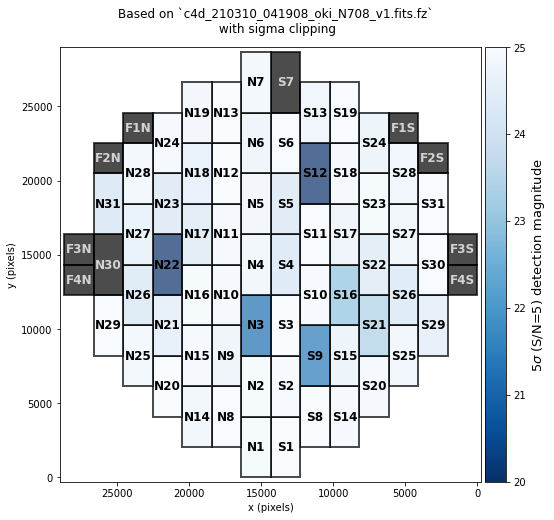

In [163]:
cmap = plt.get_cmap('Blues_r').copy()
cmap.set_bad('k', 1.)
norm = Normalize(vmin=20, vmax=25)

fig, ax = plt.subplots(figsize=(8, 8))

for ccdnum in DECam_FP_layout.keys():
    chip = DECam_FP_layout[ccdnum]
    ccdpos = chip['name']

    mag_thresh = (S2N_dict[chip['name']] - np.log10(5)) / 0.4 if ccdpos in S2N_dict.keys() else np.nan
    
    rect = Rectangle(xy=(chip['x1'], chip['y1']), 
                     width=(chip['x2'] - chip['x1']),
                     height=(chip['y2'] - chip['y1']), 
                     linewidth=2,
                     zorder=10,
                     facecolor=cmap(norm(mag_thresh)),
                     alpha=0.7,
                     edgecolor='k')
    
    ax.add_artist(rect)
    text = detector_pos[ccdnum]
    textcolor = 'lightgray' if mag_thresh is np.nan else 'k'
    
    cx = chip['x1'] + (chip['x2'] - chip['x1']) / 2.0
    cy = chip['y1'] + (chip['y2'] - chip['y1']) / 2.0
    ax.annotate(text, (cx, cy), color=textcolor, weight='bold', 
                fontsize=12, ha='center', va='center', zorder=12)
    
ax.ticklabel_format(style='plain')
ax.set_xlim(29000, -300)
ax.set_ylim(-300, 29000)
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')


divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), 
                    cax=cax1, label=r'$5\sigma$ detection magnitude')
cbar.ax.set_ylabel(r'$5\sigma$ (S/N=5) detection magnitude', fontsize=13)

plt.suptitle(f'Based on `{filename}`\n with sigma clipping', y=0.95)

#plt.savefig('./SN_test_focal_plane.png', bbox_inches='tight', dpi=100)